# Data utilities in pygris

Users of my R packages will be familiar with [__tidycensus__](https://walker-data.com/tidycensus), which is an interface to several US Census Bureau APIs.  I don't have any plans to port __tidycensus__ to Python; Python already has excellent resources for using the APIs such as [__cenpy__](https://cenpy-devs.github.io/cenpy/), which is my personal favorite.  

That said, __pygris__ users may find it helpful to pull in data from the Census Bureau to join to Census shapefiles for mapping.  __pygris__ includes some low-level data access helpers to assist with these tasks.  

## Accessing the US Census Bureau APIs

One of my favorite R packages is [censusapi]() by Hannah Recht, which offers a unified interface to all of the Census Bureau's APIs.  The `get_census` function in __pygris__ is inspired by this package.  

`get_census()` helps you make requests to the Census API and get back pandas DataFrames.  It is a relatively low-level interface in that it requires some knowledge of the Census API to get working.  Users supply a dataset name and a list of variables along with a dict of parameters to send to the Census API.  

Let's reproduce [the example in Chapter 11 of my book](https://walker-data.com/census-r/other-census-and-government-data-resources.html#accessing-census-data-resources-with-censusapi) _Analyzing US Census Data: Methods, Maps, and Models in R_.  This example pulls data from the [Small Area Health Insurance Estimates (SAHIE) API](https://www.census.gov/programs-surveys/sahie/data/api.html) for the entire United States on the percent of the population below age 19 without health insurance.  

In [7]:
from pygris.data import get_census

us_youth_sahie = get_census(dataset = "timeseries/healthins/sahie",
                            variables = "PCTUI_PT",
                            params = {
                                "for": "county:*",
                                "in": "state:*",
                                "time": 2019,
                                "AGECAT": 4
                            }, 
                            return_geoid = True, 
                            guess_dtypes = True)

In [8]:
us_youth_sahie.head()

,PCTUI_PT,time,AGECAT,GEOID
1,2.7,2019,4,01001
2,3.4,2019,4,01003
3,3.6,2019,4,01005
4,3.1,2019,4,01007
5,4.7,2019,4,01009


The `return_geoid = True` argument (default `False`) attempts to assemble a GEOID column from contextual information about the location by concatenating state and county FIPS codes.  This will not work with all datasets (specifically those where a GEOID column does not make sense), so use this option with care.  The `guess_dtypes = True` argument (default `False`) will try to guess which columns should be converted to numerics given that the Census API returns all columns as strings by default.  Use this option on a case-by-case basis.  

We can now retrieve county shapes for visualization, join the SAHIE data to those shapes, and make a map of the results.  

Text(0.5, 1.0, '% uninsured under age 19 by county, 2019')

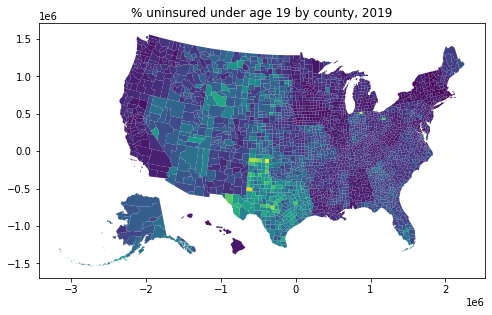

In [13]:
from pygris import counties 
from pygris.utils import shift_geometry
from matplotlib import pyplot as plt

us_counties = counties(cb = True, resolution = "20m", cache = True, year = 2019)
us_counties_rescaled = shift_geometry(us_counties)

us_counties_merged = us_counties_rescaled.merge(us_youth_sahie, on = "GEOID")

us_counties_merged.plot(
    column = "PCTUI_PT",
    cmap = "viridis",
    figsize = (8, 6)
)

plt.title("% uninsured under age 19 by county, 2019")


The Census Bureau allows users to make up to 500 requests to its API per day without an API key.  If you plan to use the API more than that, be sure to sign up for an API key at https://api.census.gov/data/key_signup.html and specify it in `params` with `"key"` as the key in the dict.  

## Accessing LODES data

The LEHD origin-destination employment statistics (LODES) dataset is another one of my favorites for understanding economic and social patterns within the United States.  The `get_lodes()` function in __pygris__ pays homage to the excellent [__lehdr__ R package by Jamaal Green, Dillon Mahmoudi, and Liming Wang](https://github.com/jamgreen/lehdr).  LODES provides synthetic Census block-level information about residence area characteristics (RAC), worker area characteristics (WAC), and origin-destination flows between home and work (OD).  

Let's say I want block-to-block origin-destination flows for the state of Texas.  I can use `get_lodes()` to pull down the LODES origin-destination file.  Be patient if downloading for the first time - this is a big file!  As with shapefiles in __pygris__, the argument `cache = True` will download the file to a cache directory for future use.  

In [1]:
from pygris.data import get_lodes

tx_od = get_lodes(state = "TX", year = 2022, lodes_type = "od", cache = True)

tx_od.head()

,index,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03
0,0,480019501001005,480019501001080,1,0,1,0,0,0,1,0,1,0
1,1,480019501001005,480019501002041,1,0,0,1,0,0,1,0,1,0
2,2,480019501001005,480019501002128,1,0,0,1,0,0,1,0,1,0
3,3,480019501001005,480019501003048,1,0,1,0,0,1,0,0,1,0
4,4,480019501001005,480019501003080,1,1,0,0,0,0,1,0,1,0


The dataset represents block-to-block flows between home and work in 2022.  The column `S000` represents all jobs, and the other columns then represent jobs broken out by category.  [Users should review the LODES documentation for more information about options and column definitions](https://lehd.ces.census.gov/data/lodes/LODES7/LODESTechDoc7.5.pdf).

`get_lodes()` includes some additional tools that makes it easier to aggregate then map the data.  Let's say I want to understand the home locations of people who commute to my place of employment, TCU.  I'll visualize this by Census tract for home locations in Tarrant County.  We'll add a couple arguments to `get_lodes()`: `agg_level = "tract"`, which will roll up our data to the Census tract level, and `return_geometry = True`, which will attach Census tract geometry to the LODES data and return a GeoDataFrame.  For origin-destination flows, the geometry will default to home locations, but this can be changed with the `od_geometry` argument.

In [2]:
tx_od_tract = get_lodes(state = "TX", year = 2022, lodes_type = "od", cache = True,
                  return_geometry = True, agg_level = "tract")

tx_od_tract.head()

Requesting feature geometry.
Using FIPS code '48' for input 'tx'


,h_geocode,geometry,w_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03
0,48195950100,"POLYGON ((-101.62392 36.49953, -101.59659 36.4...",48017950102,1,0,0,1,0,1,0,1,0,0
1,48195950100,"POLYGON ((-101.62392 36.49953, -101.59659 36.4...",48027021304,1,0,1,0,1,0,0,0,0,1
2,48195950100,"POLYGON ((-101.62392 36.49953, -101.59659 36.4...",48029121404,1,1,0,0,0,1,0,0,0,1
3,48195950100,"POLYGON ((-101.62392 36.49953, -101.59659 36.4...",48063950101,1,0,1,0,0,0,1,0,1,0
4,48195950100,"POLYGON ((-101.62392 36.49953, -101.59659 36.4...",48065950100,10,1,8,1,1,0,9,5,4,1


With this information in hand, we can subset our data by work geocode to the tracts containing TCU, and by home geocode to those in Tarrant County, Texas.  After this, we use `.explore()` to make a map of our data.

In [3]:
tcu_ids = ["48439104203", "48439104301"]

tcu_origins = tx_od_tract.loc[(tx_od_tract['w_geocode'].isin(tcu_ids)) & (tx_od_tract['h_geocode'].str.slice(stop = 5) == "48439")]

tcu_origins.explore(column = "S000")

Commuters to the University area commonly come from neighborhoods to the south and west.  Additional work to improve this analysis could normalize the data to adjust for the size of the total workforce in the tract, or expand to beyond a single county.  

## Other datasets

I could foresee the `data` module of __pygris__ as accommodating "other interesting datasets that can be merged to Census geometries" in the future.  If you have any ideas, please let me know or consider submitting a pull request!